## Imports

In [47]:
import math
import matplotlib
import matplotlib.pyplot as plots
import numpy as np
import pandas as pd
import scipy
import sklearn

from scipy import *
from scipy.signal import find_peaks, find_peaks_cwt, savgol_filter
from sklearn.metrics import mean_absolute_error

%matplotlib inline
plots.rcParams["figure.figsize"] = (10,7)

import time

## Data
`Peak_Interval_List.csv` and `Ig110postbakemap9476.CSV` from
Graphite Raman Mapping (Project 31) on Box.

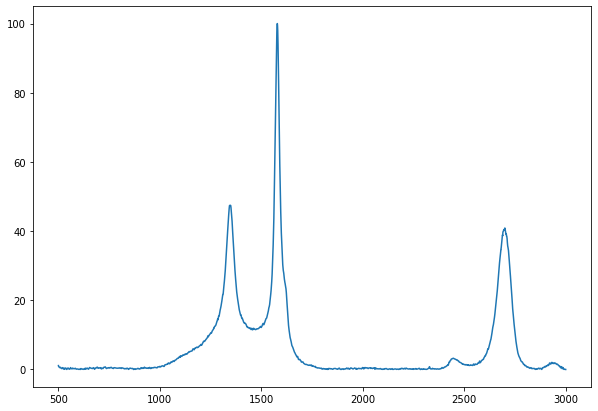

In [48]:
peak_intervals = pd.read_csv("Peak_List.csv")
sample_spectrum = pd.read_table("Data/JQ2a2_16.csv", sep=",")
plots.plot(sample_spectrum["x"], sample_spectrum["y"])

In [49]:
peak_intervals

,Peak Name,Peak Number,Optional?,Min Bound X,Max Bound X
0,Pre-D,1,Yes,1000,1320
1,D,2,No,1340,1360
2,D-G shoulder,3,Yes,1370,1550
3,G,4,No,1560,1600
4,D' shoulder,5,No,1600,1630
5,T+D,6,Yes,2300,2500
6,G'_3Da,7,No,2640,2690
7,G'_2D,8,No,2680,2720
8,G'_3DB,9,No,2700,2740
9,D'+D,10,No,2850,2950


## Driver Function
`spectrum`: table with two columns: x and y <br>  
`num_peaks`: int, how many peaks to fit with <br>  
`baseline_deg`: degree of polynomial to fit baseline with  <br>  
`baseline_tol`: tolerance to stop baseline iteration  <br>  
`peak_type`: lorentz/gaussian, later add option to choose others (examples in the matlab, should be able to express with the same parameters) <br>  
`error`: MAE, MSE, etc. <br>  
`tolerance`: to within what error should we fit <br>  
`num_iterations`: how many iterations should we go through <br>  
`window_len`: length of savitsky-golay filter window <br>  
`polyorder`: order of polynomial to fit samples in savitsky-golay

In [50]:
INITIAL_GUESS = np.asarray([7.37908, 34.97015, 3.65915, 36.15784, 4.22964, 2.89295, 5.91514, 17.67787, 10.7548, 2.4001,
                            1275.74783, 1348.01504, 1493.83166, 1581.71285, 1620.46057, 2456.79433, 2666.37302, 2694.74791, 2721.62489, 2940.27771,
                            215.7532, 44.50159, 92.21057, 23.70187, 24.28155, 67.71584, 59.9331, 47.47378, 40.57773, 58.14838])

In [92]:
def fit_spectrum(spectrum, num_peaks, baseline_deg, baseline_tol, peak_type, error_type, tolerance, 
                 num_iterations, window_len, polyorder):
    # Restruct x data to 500-3000
    restricted_spectrum = spectrum[spectrum["x"].between(500, min(3000, spectrum["x"].max()))]
    # Smooth signal with Savistky-Golay filter
    smoothed_y = scipy.signal.savgol_filter(restricted_spectrum["y"], window_len, polyorder)
    smoothed_spectrum = restricted_spectrum.assign(y=smoothed_y)
    # Remove baseline
    baseline_removed_spectrum = remove_baseline(smoothed_spectrum, baseline_deg, baseline_tol)
    # Normalize spectrum
    normalized_y = ((baseline_removed_spectrum["y"] - baseline_removed_spectrum["y"].min()) / 
        (baseline_removed_spectrum["y"].max() - baseline_removed_spectrum["y"].min()))
    normalized_spectrum = smoothed_spectrum.assign(y=normalized_y)
    
    # Create bounds
    amp_bounds = [(0.0001, 300) for i in range(num_peaks)]
    min_x = peak_intervals["Min Bound X"]
    max_x = peak_intervals["Max Bound X"]
    cen_bounds = [(min_x[i], max_x[i]) for i in range(num_peaks)]
    wid_bounds = [(0.0001, 400) for i in range(num_peaks)]
    bounds = amp_bounds + cen_bounds + wid_bounds
    
    # Create constraints
    # ensure center of peak 9 > peak 8
    cons1 = {"type": "ineq", "fun": lambda arr: arr[num_peaks + 8] - arr[num_peaks + 7]}
    # upper bound for peak 7 : peak 9 (amplitude)
    cons2 = {"type": "ineq", "fun": lambda arr: arr[6] / arr[8] - 0.45}
    # lower bound for peak 7 : peak 9 (amplitude)
    cons3 = {"type": "ineq", "fun": lambda arr: -(arr[6] / arr[8]) + 0.55}
    constraints = [cons1, cons2, cons3]
    
    # for testing purposes
    constraints = None
    
    # Initial guess
    initial_guess = INITIAL_GUESS
    # minimization
    error = error_between(normalized_spectrum, error_type, num_peaks)
    results = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=tolerance,
                                     options={"maxiter": num_iterations}, constraints=constraints)
    
    # Plotting
    plot_spectrum(normalized_spectrum, results.x, num_peaks)
    
    return results

## Error function

In [52]:
def error_between(original, error_type, num_peaks):
    def error(guess_array):
        amp = guess_array[0:num_peaks]
        cen = guess_array[num_peaks:2*num_peaks]
        wid = guess_array[2*num_peaks:3*num_peaks]
        guess_peaks = pd.DataFrame({"amp": amp, "cen": cen, "wid": wid})
        reconstructed = reconstruct_spectrum(original["x"], guess_peaks)

        if error_type == "MAE":
            e = sklearn.metrics.mean_absolute_error(original["y"], reconstructed)
        elif error_type == "MSE":
            e = sklearn.metrics.mean_squared_error(original["y"], reconstructed)
        elif error_type == "MAPE":
            e = sklearn.metrics.mean_absolute_percentage_error(original["y"], reconstructed)
        elif error_type == "RMSPE":
            e = RMSPE(original["y"], reconstructed)
        else:
            raise Exception("Error type not supported")
        return e
    return error

## Plotting
Plots original, reconstructed, and every individual peak

In [53]:
def plot_spectrum(original, parameter_vector, num_peaks):
    amp = parameter_vector[0:num_peaks]
    cen = parameter_vector[num_peaks:2*num_peaks]
    wid = parameter_vector[2*num_peaks:3*num_peaks]
    parameter_matrix = pd.DataFrame({"amp": amp, "cen": cen, "wid": wid})
    reconstructed_y = reconstruct_spectrum(original["x"], parameter_matrix)
    plots.plot(original["x"], original["y"], color="red", label="Real")
    plots.plot(original["x"], reconstructed_y, color="blue", label="Reconstructed")
    
    result_dict = {"Peak #": np.arange(num_peaks),
                    "amp": parameter_vector[0:num_peaks],
                    "cen": parameter_vector[num_peaks:2*num_peaks],
                    "wid": parameter_vector[2*num_peaks:3*num_peaks]}
    result_matrix = pd.DataFrame(result_dict)
    for i in range(num_peaks):
        parameters_i = result_matrix.iloc[i]
        amp_i = parameters_i["amp"]
        cen_i = parameters_i["cen"]
        wid_i = parameters_i["wid"]
        peak_i = [lorentz(x, amp_i, cen_i, wid_i) for x in original["x"]]
        plots.plot(original["x"], peak_i, color="green", label=f"Peak{i+1}")
                   
    plots.legend()
    return

## Baseline Fitting

Returns array same length as spectrum x. 

In [54]:
def baseline(spectrum, deg, tol):
    s = spectrum
    e = float(inf)
    old_coefs = None
    nrows = 0
    
    while e > tol:
        if len(spectrum.index) == 0:
            break
        # create fit line w/ np.polyfit & turn into a function w/ polyn
        coef = np.polyfit(spectrum["x"], spectrum["y"], deg, full=False)
        polyn = make_polynomial(coef, deg)
        # re-fit line to remaining points
        
        baseline_fit = spectrum["x"].apply(polyn)
        
        # do error b/t previous line
        if type(old_coefs) != type(None):
            e = RMSPE(baseline_fit, spectrum["x"].apply(make_polynomial(old_coef, deg)))
        # remove any points above fit line
        spectrum = spectrum[spectrum["y"] <= baseline_fit]
        # repeat until fitting error < tol or # points doesn't change
        old_coef = coef
        # additional case to ensure enough of baseline remains - could modify starting condition instead
        if abs(nrows - len(spectrum.index)) < 75:
            break
        if len(spectrum.index) == nrows:
            print("nrows exit")
            break
        nrows = len(spectrum.index)
    # changed spectrum
    baseline_ret = s["x"].apply(polyn)
    return baseline_ret           

In [55]:
# takes in a table and returns a table w/ same columns & dimensions
def remove_baseline(spectrum, deg, tol):
    bl = baseline(spectrum, deg, tol)
    spectrum["y"] = spectrum["y"] - bl
    return spectrum

In [56]:
# returns a single-variable polynomial function of degree deg from coefficients coef
def make_polynomial(coef, deg):
    # takes in an array of x values and returns an array of y values of the same dimension
    def polyn(x):
        y = 0
        for i in range(deg + 1):
            y += pow(x, deg - i) * coef[i]
        return y
    return polyn

In [57]:
# returns an array with num_peaks x-values set to the midpoint of their bounds
# add option to remove peaks that are not required for lower num_peaks
def detect_peaks(spectra, num_peaks):
    midpoints = (peak_intervals.column("Min Bound X") + peak_intervals.column("Max Bound X")) / 2
    return midpoints

In [58]:
# returns a matrix of initial guesses
# dimensions 4 x num_peaks (4 = num parameters - x)
def create_peaks(peak_type, detected_peaks):
    if peak_type == "lorentz":
        parameter_matrix = Table(["Peak #", "amp", "cen", "wid"])
        for i in np.arange(len(detected_peaks)):
            amp = guess_amp()
            cen = detected_peaks[i]
            wid = guess_wid()
            parameter_matrix.append([i, amp, cen, wid])
        return parameter_matrix
    elif peak_type == "gaussian":
        return False

In [59]:
# x - values where the function is calculated
# y_0 - baseline
# amp - area
# cen - peak's center position
# wid - controls full width half maximum of the function
def lorentz(x, amp, cen, wid):
    return (amp/np.pi)*(wid / ((x - cen) ** 2 + wid ** 2))

In [60]:
# x - values where the function is calculated
# y_0 - baseline
# height - height of peak
# center - center of peak
# std - standard deviation
def gaussian(x, y_0, amp, cen, wid):
    std=wid/2.355
    return (amp / (std * np.sqrt(2*np.pi))) * (np.e ** -(((x - center) ** 2)) / 2 * std ** 2) + y_0

In [89]:
# returns an array of y values for each x value in spectrum. y values obtained using peak_parameters
def reconstruct_spectrum(spectrum_x, peak_parameters):
    def reconstruct_sum(x):
        sum_peaks = peak_parameters.apply(lambda params: lorentz(x, params[0], params[1], params[2]), axis=1, raw=True)
        return np.sum(sum_peaks)
    reconstructed = [reconstruct_sum(x) for x in spectrum_x]
    return reconstructed

In [86]:
def RMSPE(y_true, y_pred):
    EPSILON = 1e-10
    return (np.sqrt(np.mean(np.square((y_true + EPSILON - y_pred) / y_true + EPSILON)))) * 100

# Testing - Optimization

May take up to 3.5 minutes to run with 0.000001 tolerance

      fun: 1.0380661806444673
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.76828770e+01,  8.79802549e+00,  9.38462390e+00,  1.49539355e+01,
        1.67531337e+01,  1.71309374e+02,  4.76799534e+01,  4.13393753e+01,
        3.77899229e+01,  1.77071622e+01, -8.43964717e-01,  1.86519441e-06,
       -5.77322078e-06,  4.13007333e-06,  4.86282827e-06,  2.13389014e+00,
       -2.35147723e-05, -1.90294239e-05, -1.81412361e-05, -5.39574096e-06,
        4.87635936e+00,  8.79802549e+00,  9.38462403e+00,  1.49539355e+01,
        1.67531337e+01,  1.70196483e+02,  4.76799534e+01,  4.13393753e+01,
        3.77899229e+01,  1.77071622e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 248
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000036e

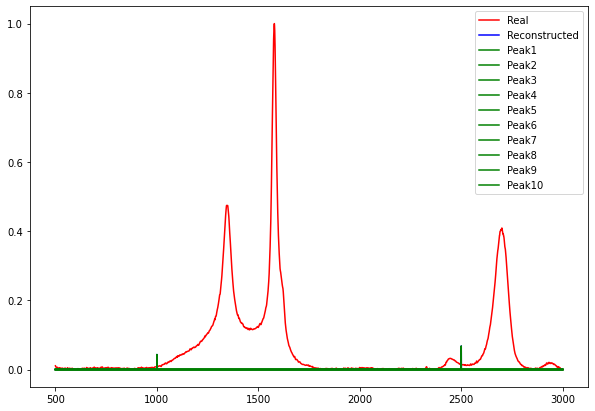

In [94]:
fit_spectrum(sample_spectrum, 10, 1, 0.01, "lorentz", "MAPE", 0.0001, 100, 15, 2)

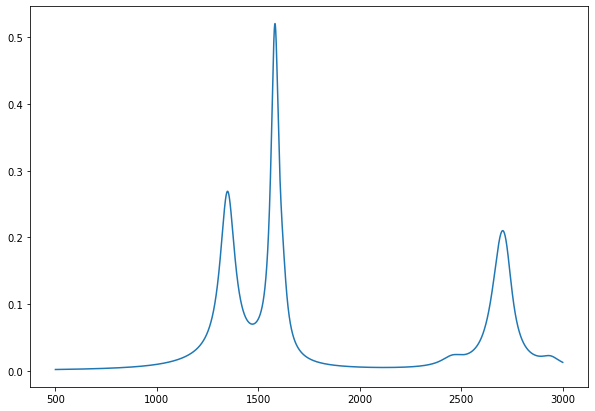

In [95]:
num_peaks = 10
amp = INITIAL_GUESS[0:num_peaks]
cen = INITIAL_GUESS[num_peaks:2*num_peaks]
wid = INITIAL_GUESS[2*num_peaks:3*num_peaks]
parameter_matrix = pd.DataFrame({"amp": amp, "cen": cen, "wid": wid})
reconstructed_y = reconstruct_spectrum(sample_spectrum["x"], parameter_matrix)
plots.plot(sample_spectrum["x"], reconstructed_y)

In [78]:
parameter_matrix.iloc[0][

7.37908

# Testing - Pandas

In [82]:
dic = {'A': [1, 4, 1, 4], 'B': [9, 2, 5, 3], 'C': [0, 0, 5, 3]}
df = pd.DataFrame(dic)
df

,A,B,C
0,1,9,0
1,4,2,0
2,1,5,5
3,4,3,3


In [84]:
df.apply(lambda x: max(x), axis=1)

0    9
1    4
2    5
3    4
dtype: int64

## Up Next:
Baseline (try fitting algorithm in reading list) <br>  
Add different errors <br>  
Output error from driver <br>  
Add the option to fit with less peaks (with/without 1&3) Do this automatically. Let user choose if this happens. <br>  


Future optimization: do operations in place
Check peak interval against spectrum range to see if we need to
    fit with a different number of peaks
Initial guess: try using generalized results of completed optimization? Or try finding prominent peaks and using those as a starting point

Have to figure out what the type of guess will be - series or ndarray.
Maybe try to use multithreading in spectrum reconstruction.
Used in optimization.